# Setup

In [ ]:
from progpy.discrete_state import create_discrete_state

# Example 1: Random Transition

In [4]:
# Setup
StateType = create_discrete_state(10)
x = StateType(1)
print(x)

Discrete State.State 1


In [5]:
# Less than transition
x + 0.4

<Discrete State.State 1: 1>

In [6]:
# Greater than transition
x + 0.51

<Discrete State.State 4: 4>

In [7]:
# Repeat: Greater than transition
x + 0.51

<Discrete State.State 5: 5>

# Example 2: Sequential

In [8]:
# Setup
StateType = create_discrete_state(10, transition='sequential')
x = StateType(1)
print(x)

Discrete State.State 1


In [9]:
# Less than transition
x + 0.4

<Discrete State.State 1: 1>

In [10]:
# Greater than transition
x + 0.51

<Discrete State.State 2: 2>

In [11]:
# Again - Greater than transition
x + 0.51

<Discrete State.State 2: 2>

In [12]:
# Double transition
x + 0.51 + 0.51

<Discrete State.State 3: 3>

In [13]:
# Transition by more than 1
x + 1.51

<Discrete State.State 3: 3>

# Example 3: Custom Transition

In [14]:
def transition(current_state, amount_added):
    # this is an example function- in reality it could be anything
    # Transition in this case is from 1-> any state and
    #  if not in state 1 can only transition back to 1
    if current_state == 1 and amount_added > 0.5:
        return random.randint(0, len(type(current_state))-1)
    elif amount_added > 0.5:
        return 1
    else:  # No transition
        return current_state

In [15]:
# Setup
StateType = create_discrete_state(10, transition=transition)
x = StateType(1)
print(x)

Discrete State.State 1


In [16]:
# below transition amount
x + 0.49

<Discrete State.State 1: 1>

In [45]:
# State 1 can transition to anything
x + 0.51

: 

In [18]:
# Again - State 1 can transition to anything
x + 0.51

<Discrete State.State 1: 1>

In [19]:
# Any state other than 1 will always transition to 1
StateType(2) + 0.51

<Discrete State.State 1: 1>

# Example 4: Integration into progpy

Example filling tank with valve which can be open/closed

In [22]:
import math
from progpy import PrognosticsModel
ValveState = create_discrete_state(2, ['open', 'closed'])

class Tank(PrognosticsModel):
    inputs = ['q_in', 'valve_command']
    states = [
        'valve', # Valve state (discrete)
        'h' # height of water
    ]
    outputs = ['h']
    events = ['full']

    default_parameters = {
        'crosssection_area': 1, # m^2
        'height': 1, # m
        'rho': 1000, # fluid density kg/m^3 (default water)
        'g': -9.81, # Acceleration due to gravity in m/s^2
        'valve_r': 3e-3, # m
        'valve_l': 0.001, # m
        'viscosity': 1e-3, # Pa*s
        'x0': {
            'valve': ValveState.closed,
            'h': 0, # Starts empty
        }
    }

    def next_state(self, x, u, dt):
        x['valve'] = ValveState(u['valve_command'])
        p = self['rho']*self['g']*x['h'] # Pressure in N
        if x['valve'] == ValveState.open:
            q_out = p*math.pi*self['valve_r']**4/ (8*self['viscosity']*self['valve_l']) # flow rate m^3/s
        else:
            q_out = 0
        x['h'] += (u['q_in']+q_out) * dt/self['crosssection_area']
        x['h'] = min(max(x['h'], 0), self['height'])
        return x

    def output(self, x):
        return self.OutputContainer({'h': x['h']})

    def event_state(self, x):
        return {'full': (self['height']-x['h'])/self['height']}

In [23]:
m = Tank()

In [24]:
def stupid_load(t, x=None):
    # Doesn't open valve
    if x is None:
        return m.InputContainer({'q_in': 0.1, 'valve_command': ValveState.closed})
    return m.InputContainer({'q_in': 0.1, 'valve_command': x['valve']})

/Users/cteubert/dev/progpy/src/progpy/exceptions.py:20: UserWarning: Behavior of SimResult.plot() will change with version 1.6. New behavior will match that of a pandas data frame.
  warn(msg, *args, **kwargs)


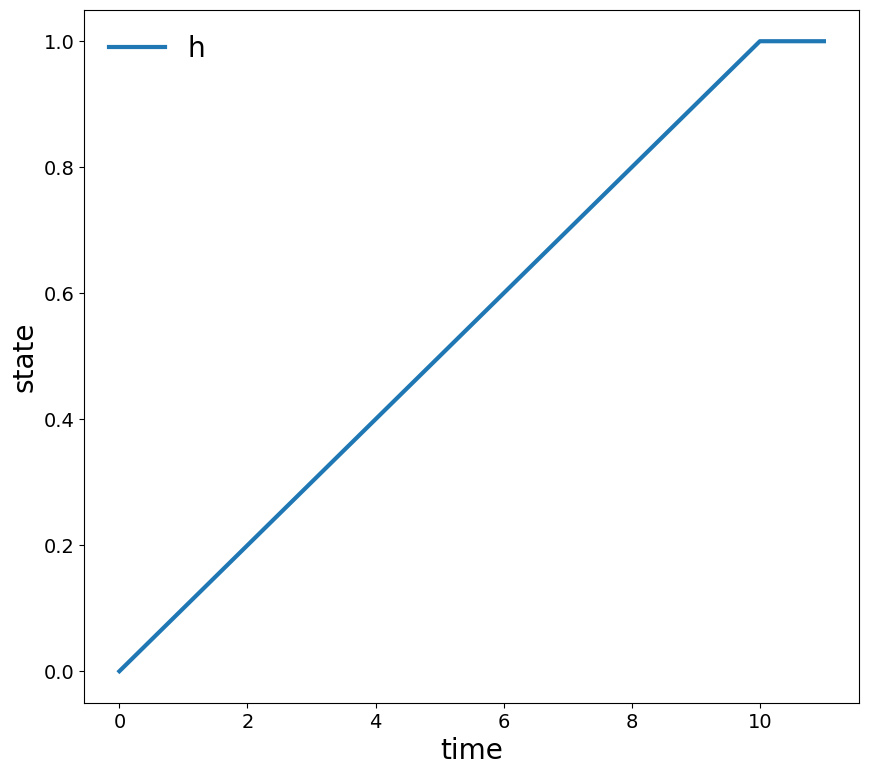

In [25]:
result = m.simulate_to_threshold(stupid_load, save_freq=1, horizon=25)
fig = result.outputs.plot()

In [26]:
def smart_load(t, x=None):
    if x is None:
        # First step
        return m.InputContainer({'q_in': 0.1, 'valve_command': ValveState.closed})

    if (x['valve'] == ValveState.closed) and (x['h'] >= m['height']*0.8):
        # If closed, open at 80% full
        return m.InputContainer({'q_in': 0.1, 'valve_command': ValveState.open})
    elif (x['valve'] == ValveState.open) and (x['h'] <= m['height']*0.6):
        # If open, close at 60% full
        return m.InputContainer({'q_in': 0.1, 'valve_command': ValveState.closed})
    
    # Default- dont control valve
    return m.InputContainer({'q_in': 0.1, 'valve_command': x['valve']})
    

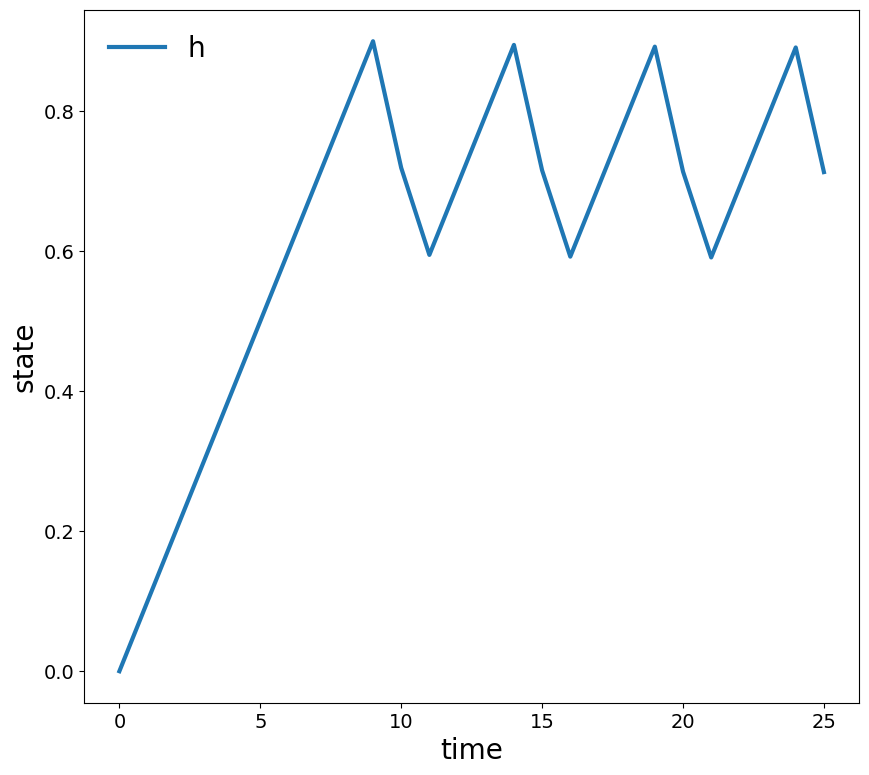

In [27]:
result = m.simulate_to_threshold(smart_load, save_freq=1, horizon=25)
fig = result.outputs.plot()

Now With noise!

In [38]:
m['process_noise'] = m.StateContainer({'valve': 1, 'h': 0})
m['process_noise_dist'] = 'uniform' # will switch the valve 33% of the time

This will randomly open and close the valve

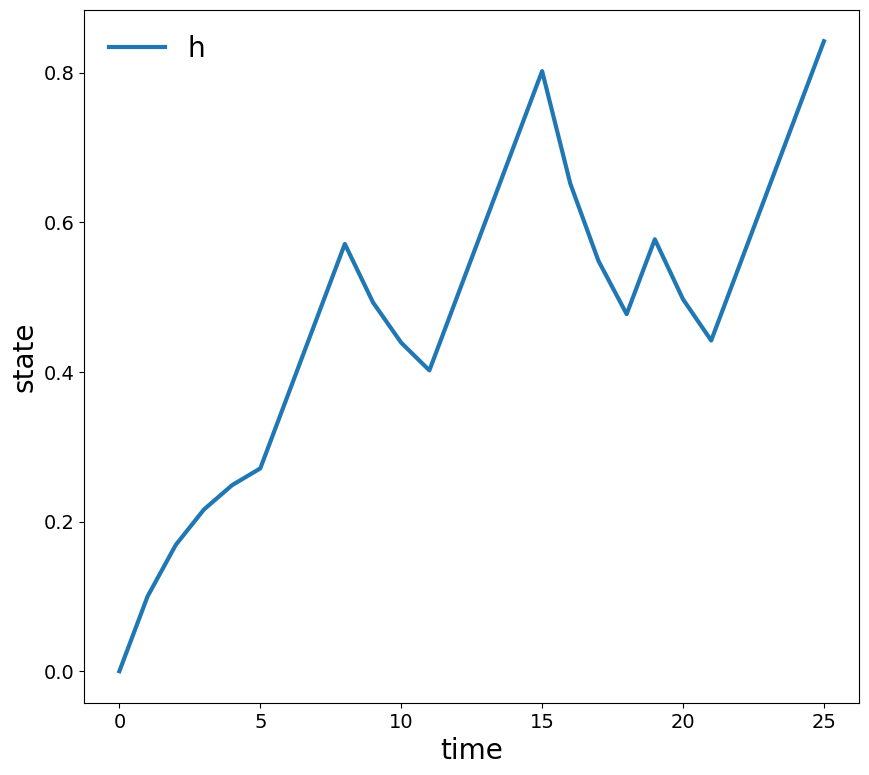

In [39]:
result = m.simulate_to_threshold(stupid_load, save_freq=1, horizon=25)
fig = result.outputs.plot()